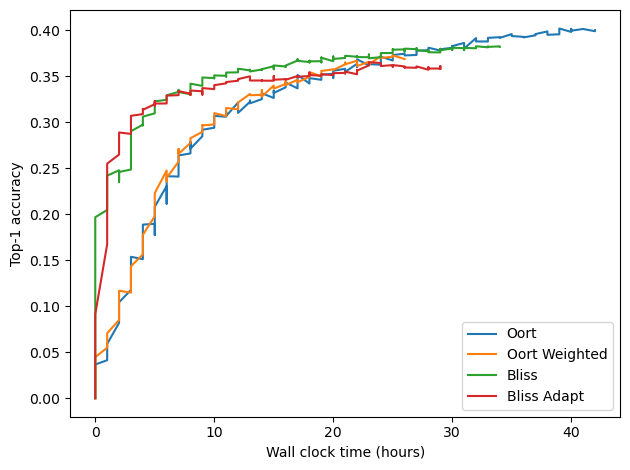

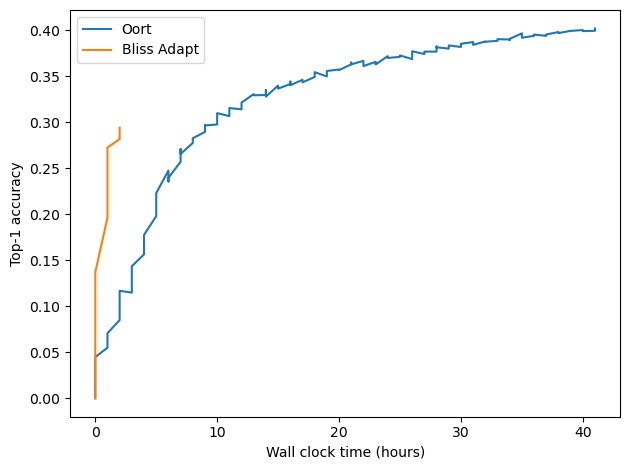

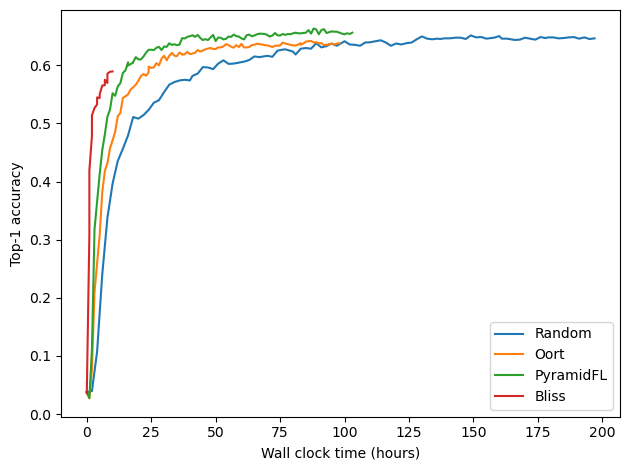

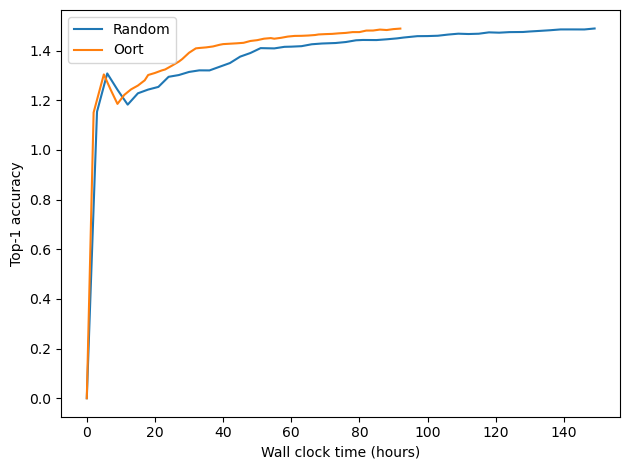

In [2]:
import ast
import math
import re
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt

BASE_LOG_DIR = Path("../run_global_loggings")


def _format_job_label(job_name: str) -> str:
    label = job_name.replace("_", " ")
    return label.replace("adaptP1", "Phase 1")


def _collect_results(folder_name: str, job_name: str) -> List[Dict[str, float]]:
    log_path = BASE_LOG_DIR / folder_name / job_name
    results: List[Dict[str, float]] = []
    if not log_path.exists():
        print(f"Skipping missing log file: {log_path}")
        return results
    if log_path.is_dir():
        print(f"Skipping directory path (expected file): {log_path}")
        return results
    pattern = re.compile(r"results:\s*(\{.*\})")
    with log_path.open("r") as handle:
        for line in handle:
            if "top_1" not in line:
                continue
            match = pattern.search(line)
            if not match:
                continue
            try:
                payload = ast.literal_eval(match.group(1))
            except (ValueError, SyntaxError):
                continue
            results.append(
                {
                    "round": int(payload.get("round", 0)),
                    "clock_hours": int(math.floor(float(payload.get("clock", 0.0)) / 3600.0)),
                    "top_1": float(payload.get("top_1", 0.0)),
                    "loss": float(payload.get("loss", 0.0)),
                }
            )
    return results


def plot_top1_vs_time(folder_name: str, job_names: List[str]) -> None:
    fig, ax = plt.subplots()
    plotted_lines = 0
    for job_name in job_names:
        metrics = _collect_results(folder_name, job_name)
        if not metrics:
            continue
        is_so = folder_name.lower() == "stackoverflow"
        if is_so:
            x_full = [entry["clock_hours"] for entry in metrics]
            y_full = [(entry["loss"] ** 2.0) for entry in metrics]
            x, y = x_full, y_full
        else:
            x = [entry["clock_hours"] for entry in metrics]
            y = [entry["top_1"] for entry in metrics]
        ax.plot(x, y, label=_format_job_label(job_name))
        plotted_lines += 1
    if not plotted_lines:
        plt.close(fig)
        print(f"No matching results found in {folder_name} for {job_names}.")
        return
    ax.set_xlabel("Wall clock time (hours)")
    ax.set_ylabel("Perplexity (loss^2)" if folder_name.lower() == "stackoverflow" else "Top-1 accuracy")
    if plotted_lines > 0:
        ax.legend()
    fig.tight_layout()
    plt.show()

plot_top1_vs_time("OpenImage2", ["Oort", "Oort_Weighted","Bliss", "Bliss_Adapt"])
plot_top1_vs_time("OpenImage", ["Oort", "Bliss_Adapt"])
# plot_top1_vs_time("OpenImage2", ["Random", "Oort", "PyramidFL","Bliss", "Bliss_Adapt"])
plot_top1_vs_time("GoogleSpeech2", ["Random", "Oort", "PyramidFL","Bliss"])
plot_top1_vs_time("StackOverflow2", ["Random", "Oort"])

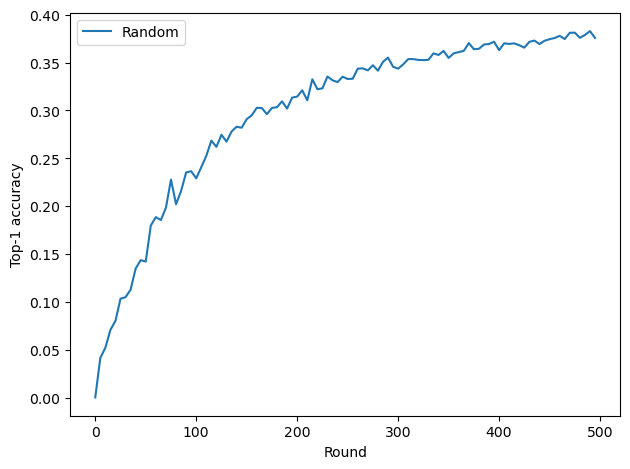

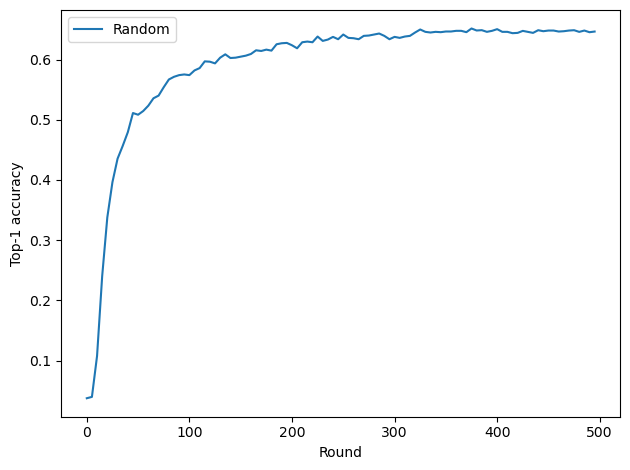

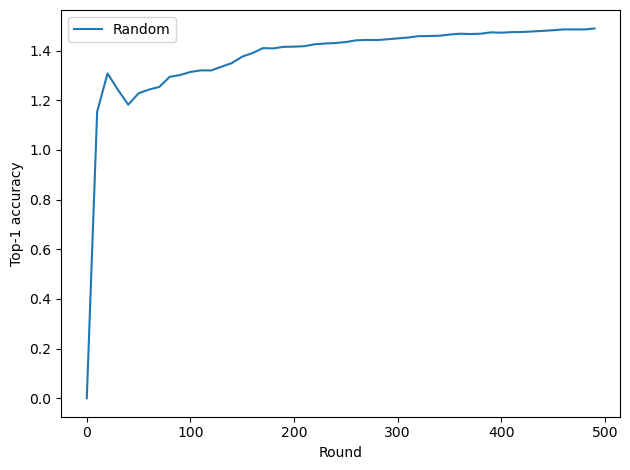

In [5]:
def plot_top1_vs_round(folder_name: str, job_names: List[str]) -> None:
    fig, ax = plt.subplots()
    plotted_lines = 0
    for job_name in job_names:
        metrics = _collect_results(folder_name, job_name)
        if not metrics:
            continue
        is_so = folder_name.lower() == "stackoverflow"
        if is_so:
            x_full = [entry["round"] for entry in metrics]
            y_full = [(entry["loss"] ** 2.0) for entry in metrics]
            x, y = x_full, y_full
        else:
            x = [entry["round"] for entry in metrics]
            y = [entry["top_1"] for entry in metrics]
        ax.plot(x, y, label=_format_job_label(job_name))
        plotted_lines += 1
    if not plotted_lines:
        plt.close(fig)
        print(f"No matching results found in {folder_name} for {job_names}.")
        return
    ax.set_xlabel("Round")
    ax.set_ylabel("Perplexity (loss^2)" if folder_name.lower() == "stackoverflow" else "Top-1 accuracy")
    if plotted_lines > 0:
        ax.legend()
    fig.tight_layout()
    plt.show()


for task in ["OpenImage", "GoogleSpeech", "StackOverflow"]:
    plot_top1_vs_round(task, ["Random"])


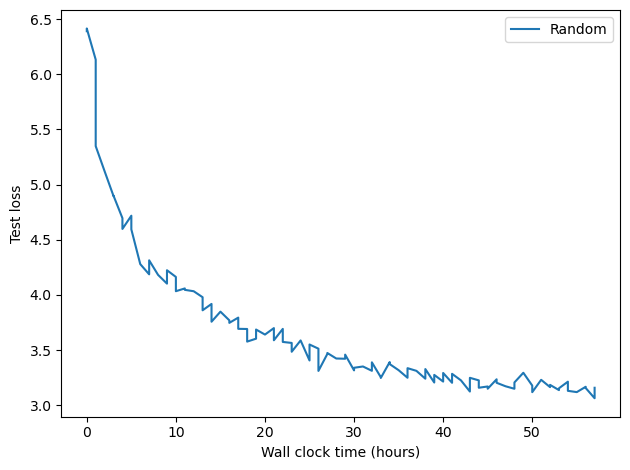

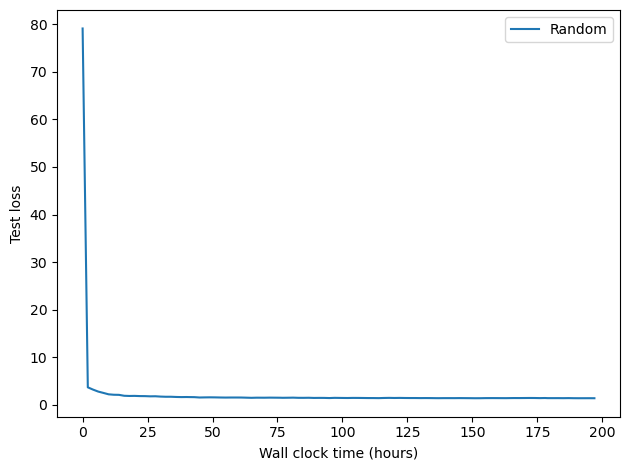

Skipping missing log file: ../run_global_loggings/StackOverflow/Random
No matching results found in StackOverflow for ['Random'].


In [7]:
def plot_loss_vs_time(folder_name: str, job_names: List[str]) -> None:
    fig, ax = plt.subplots()
    plotted_lines = 0
    for job_name in job_names:
        metrics = _collect_results(folder_name, job_name)
        if not metrics:
            continue
        x = [entry["clock_hours"] for entry in metrics]
        y = [entry["loss"] for entry in metrics]
        ax.plot(x, y, label=_format_job_label(job_name))
        plotted_lines += 1
    if not plotted_lines:
        plt.close(fig)
        print(f"No matching results found in {folder_name} for {job_names}.")
        return
    ax.set_xlabel("Wall clock time (hours)")
    ax.set_ylabel("Test loss")
    if plotted_lines > 0:
        ax.legend()
    fig.tight_layout()
    plt.show()


for task in ["OpenImage", "GoogleSpeech", "StackOverflow"]:
    plot_loss_vs_time(task, ["Random"])


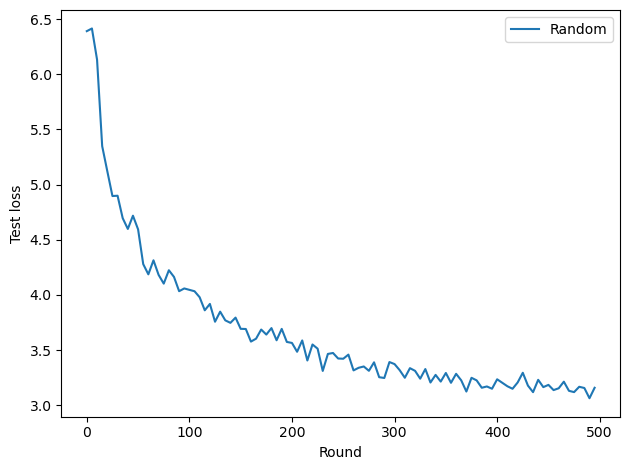

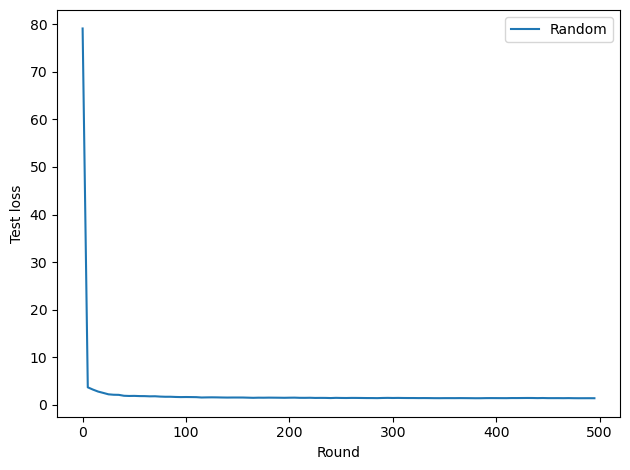

Skipping missing log file: ../run_global_loggings/StackOverflow/Random
No matching results found in StackOverflow for ['Random'].


In [8]:
def plot_loss_vs_round(folder_name: str, job_names: List[str]) -> None:
    fig, ax = plt.subplots()
    plotted_lines = 0
    for job_name in job_names:
        metrics = _collect_results(folder_name, job_name)
        if not metrics:
            continue
        x = [entry["round"] for entry in metrics]
        y = [entry["loss"] for entry in metrics]
        ax.plot(x, y, label=_format_job_label(job_name))
        plotted_lines += 1
    if not plotted_lines:
        plt.close(fig)
        print(f"No matching results found in {folder_name} for {job_names}.")
        return
    ax.set_xlabel("Round")
    ax.set_ylabel("Test loss")
    if plotted_lines > 0:
        ax.legend()
    fig.tight_layout()
    plt.show()


for task in ["OpenImage", "GoogleSpeech", "StackOverflow"]:
    plot_loss_vs_round(task, ["Random"])


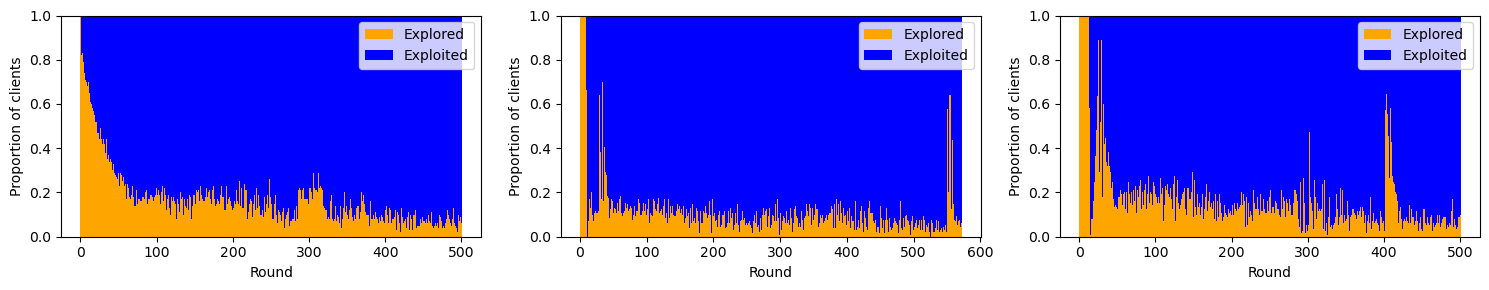

In [3]:
def plot_explore_exploit_by_round(folder_name: str, job_names: List[str]) -> None:
    # One subplot per job; stacked bars per round (explored vs exploited) that sum to 1.
    import ast
    from pathlib import Path as _Path

    present = []  # (job_name, rounds_idx, explore_props, exploit_props)

    for job_name in job_names:
        log_path = BASE_LOG_DIR / folder_name / job_name
        if not log_path.exists() or log_path.is_dir():
            print(f"Skipping missing log file: {log_path}")
            continue
        ids_per_round = []
        with log_path.open('r') as f:
            for line in f:
                # Look for participant selection lines
                if "] Selected " in line:
                    lb = line.rfind('[')
                    rb = line.rfind(']')
                    if lb == -1 or rb == -1 or rb <= lb:
                        continue
                    try:
                        ids = ast.literal_eval(line[lb:rb+1])
                    except Exception:
                        # Fallback: extract integers if the list literal fails
                        import re as _re
                        ids = [int(x) for x in _re.findall(r'\d+', line[lb:rb+1])]
                    if not isinstance(ids, list):
                        continue
                    # Coerce to ints explicitly
                    try:
                        ids = [int(x) for x in ids]
                    except Exception:
                        continue
                    ids_per_round.append(ids)
        if not ids_per_round:
            continue
        seen = set()
        explore_props, exploit_props = [], []
        for ids in ids_per_round:
            total = len(ids) if len(ids) > 0 else 1
            new = 0
            for cid in ids:
                if cid not in seen:
                    new += 1
                    seen.add(cid)
            explored = new
            exploited = total - explored
            explore_props.append(explored / total)
            exploit_props.append(exploited / total)
        rounds = list(range(len(explore_props)))
        present.append((job_name, rounds, explore_props, exploit_props))

    if not present:
        print(f"No selection lines found in {folder_name} for {job_names}.")
        return

    # Create horizontal subplots, one per job present
    n = len(present)
    fig, axes = plt.subplots(1, n, figsize=(max(5*n, 6), 3), squeeze=False)
    axes = axes.ravel()

    for idx, (job_name, rounds, explore_props, exploit_props) in enumerate(present):
        ax = axes[idx]
        xs = rounds
        # Explored (bottom) in orange
        ax.bar(xs, explore_props, width=1.0, align='edge', color='orange', edgecolor='none', linewidth=0, label='Explored')
        # Exploited (top) in blue
        ax.bar(xs, exploit_props, width=1.0, align='edge', bottom=explore_props, color='blue', edgecolor='none', linewidth=0, label='Exploited')
        ax.set_xlabel('Round')
        ax.set_ylabel('Proportion of clients')
        ax.set_ylim(0.0, 1.0)
        ax.legend()

    fig.tight_layout()
    plt.show()


plot_explore_exploit_by_round("OpenImage", ["Oort", "Bliss","Bliss_Adapt"])

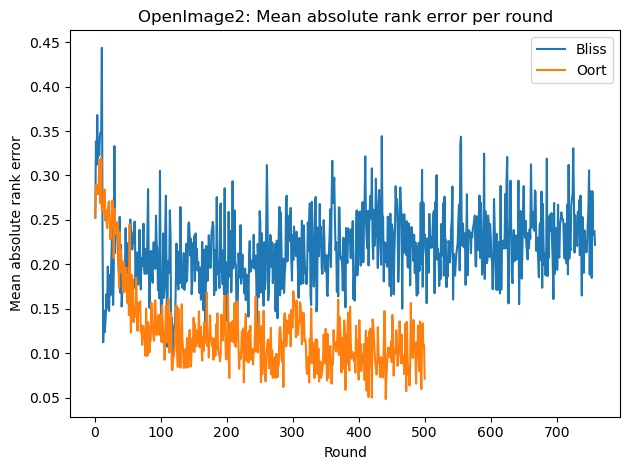

In [9]:
import json
import math


def _average_ranks(values: Dict[int, float]) -> Dict[int, float]:
    if not values:
        return {}
    sorted_items = sorted(values.items(), key=lambda item: (-item[1], item[0]))
    ranks: Dict[int, float] = {}
    idx = 0
    while idx < len(sorted_items):
        value = sorted_items[idx][1]
        j = idx + 1
        while j < len(sorted_items) and math.isclose(sorted_items[j][1], value, rel_tol=1e-12, abs_tol=1e-12):
            j += 1
        rank_value = (idx + 1 + j) / 2.0
        for k in range(idx, j):
            ranks[sorted_items[k][0]] = rank_value
        idx = j
    return ranks


def _compute_mare_per_round(log_path: Path) -> Dict[int, float]:
    results: Dict[int, float] = {}
    if not log_path.exists() or log_path.is_dir():
        return results
    with log_path.open("r") as handle:
        for line in handle:
            if "[CLIENT_INFO]" not in line:
                continue
            try:
                payload_str = line.split("[CLIENT_INFO]", 1)[1].strip()
                data = json.loads(payload_str)
            except (IndexError, json.JSONDecodeError):
                continue
            round_id = data.get("round")
            if round_id is None:
                continue
            client_info = None
            for key, value in data.items():
                if isinstance(value, dict) and key.endswith("_client_information"):
                    client_info = value
                    break
            if not client_info:
                continue
            predicted_values: Dict[int, float] = {}
            completed_values: Dict[int, float] = {}
            for client_id_str, metrics in client_info.items():
                if not isinstance(metrics, list) or len(metrics) < 9:
                    continue
                try:
                    client_id = int(client_id_str)
                except ValueError:
                    continue
                pred_val = metrics[6]
                comp_val = metrics[7]
                status = metrics[8]
                try:
                    pred_float = float(pred_val)
                except (TypeError, ValueError):
                    pred_float = float("-inf")
                if not math.isfinite(pred_float):
                    pred_float = float("-inf")
                predicted_values[client_id] = pred_float
                try:
                    comp_float = float(comp_val)
                except (TypeError, ValueError):
                    comp_float = None
                if status == "c" and comp_float is not None and math.isfinite(comp_float):
                    completed_values[client_id] = comp_float
            if not completed_values:
                continue
            predicted_ranks = _average_ranks(predicted_values)
            actual_ranks = _average_ranks(completed_values)
            if not predicted_ranks or not actual_ranks:
                continue
            total_pred = max(len(predicted_ranks), 1)
            total_actual = max(len(actual_ranks), 1)
            pred_den = max(total_pred - 1, 1)
            actual_den = max(total_actual - 1, 1)
            diffs = []
            for client_id, act_rank in actual_ranks.items():
                pred_rank = predicted_ranks.get(client_id)
                if pred_rank is None:
                    continue
                pred_norm = (pred_rank - 1) / pred_den if pred_den else 0.0
                act_norm = (act_rank - 1) / actual_den if actual_den else 0.0
                diffs.append(abs(pred_norm - act_norm))
            if not diffs:
                continue
            mare = sum(diffs) / len(diffs)
            results[int(round_id)] = mare
    return results


def plot_mare_vs_round(folder_name: str, job_names: List[str]) -> None:
    fig, ax = plt.subplots()
    plotted = 0
    for job_name in job_names:
        log_path = BASE_LOG_DIR / folder_name / job_name
        if not log_path.exists() or log_path.is_dir():
            print(f"Skipping missing log file: {log_path}")
            continue
        per_round = _compute_mare_per_round(log_path)
        if not per_round:
            continue
        rounds = sorted(per_round)
        values = [per_round[r] for r in rounds]
        ax.plot(rounds, values, label=_format_job_label(job_name))
        plotted += 1
    if not plotted:
        plt.close(fig)
        print(f"No MARE results found in {folder_name} for {job_names}.")
        return
    ax.set_xlabel("Round")
    ax.set_ylabel("Mean absolute rank error")
    ax.set_title(f"{folder_name}: Mean absolute rank error per round")
    ax.legend()
    fig.tight_layout()
    plt.show()

plot_mare_vs_round("OpenImage2", ["Bliss", "Oort"])